# playground siamMAE

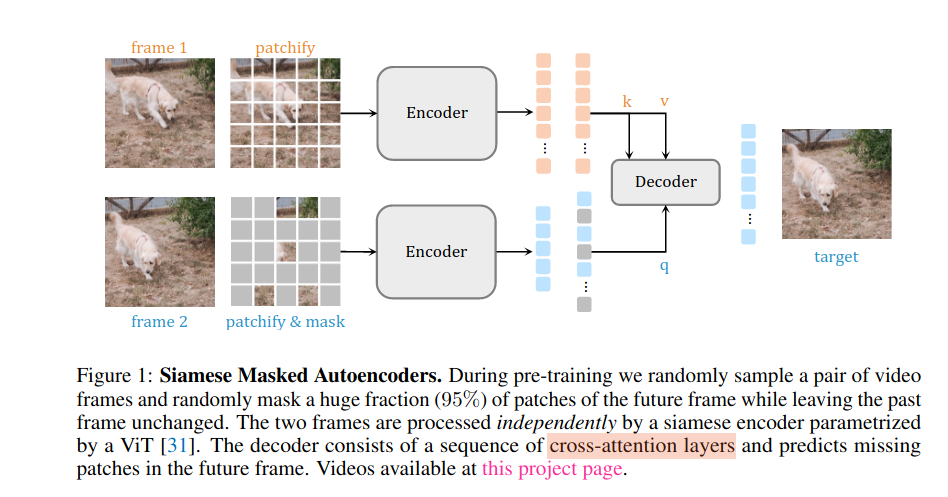

In [352]:
## Standard libraries
import os
import numpy as np
import math
import json
from functools import partial
from PIL import Image
from collections import defaultdict

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## tqdm for progress bars
from tqdm.auto import tqdm

## To run JAX on TPU in Google Colab, uncomment the two lines below
# import jax.tools.colab_tpu
# jax.tools.colab_tpu.setup_tpu()

## JAX
import jax
import jax.numpy as jnp
from jax import random
# Seeding for random operations
main_rng = random.PRNGKey(42)

## Flax (NN in JAX)
import flax
from flax import linen as nn
from flax.training import train_state, checkpoints

## Optax (Optimizers in JAX)
import optax

## PyTorch
import torch
import torch.utils.data as data
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import transforms
from torchvision.datasets import FashionMNIST, MNIST, CIFAR10

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "./data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "./my_checkpoints/tutorial15_jax"

import urllib.request
from urllib.error import HTTPError

/tmp/ipykernel_40216/2361051482.py:14: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


<Figure size 640x480 with 0 Axes>

### Import dataset

In [353]:
import torch
from torchvision.datasets import MovingMNIST, Kinetics, FashionMNIST, CIFAR10
import torchvision.transforms as transforms

# Define the path where the dataset will be downloaded
dataset_path_MovingMNIST = "../data/MovingMNIST"
dataset_path_Kinetics = "../data/Kinetics"
dataset_path_FashionMNIST = "../data/FashionMNIST"
dataset_path_CIFAR10 = "../data/CIFAR10"

DATASET_PATH = dataset_path_CIFAR10
# Transformations applied on each image => bring them into a numpy array
DATA_MEANS = np.array([0.49139968, 0.48215841, 0.44653091])
DATA_STD = np.array([0.24703223, 0.24348513, 0.26158784])
def image_to_numpy(img):
    img = np.array(img, dtype=np.float32)
    img = (img / 255. - DATA_MEANS) / DATA_STD
    return img

# We need to stack the batch elements
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

test_transform = image_to_numpy
# For training, we add some augmentation. Networks are too powerful and would overfit.
train_transform = transforms.Compose([#transforms.RandomHorizontalFlip(),
                                      #transforms.RandomResizedCrop((32,32),scale=(0.8,1.0),ratio=(0.9,1.1)),
                                      image_to_numpy
                                     ])
# Loading the training dataset. We need to split it into a training and validation part
# We need to do a little trick because the validation set should not use the augmentation.
train_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=train_transform, download=True)
val_dataset = CIFAR10(root=DATASET_PATH, train=True, transform=test_transform, download=True)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000], generator=torch.Generator().manual_seed(42))
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000], generator=torch.Generator().manual_seed(42))

# Loading the test set
test_set = CIFAR10(root=DATASET_PATH, train=False, transform=test_transform, download=True)

# We define a set of data loaders that we can use for training and validation
train_loader = data.DataLoader(train_set,
                               batch_size=128,
                               shuffle=True,
                               drop_last=True,
                               collate_fn=numpy_collate,
                               num_workers=8,
                               persistent_workers=True)
val_loader   = data.DataLoader(val_set,
                               batch_size=128,
                               shuffle=False,
                               drop_last=False,
                               collate_fn=numpy_collate,
                               num_workers=4,
                               persistent_workers=True)
test_loader  = data.DataLoader(test_set,
                               batch_size=128,
                               shuffle=False,
                               drop_last=False,
                               collate_fn=numpy_collate,
                               num_workers=4,
                               persistent_workers=True)



Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


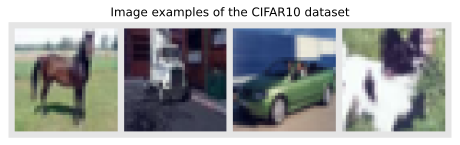

In [354]:
# Visualize some examples
def numpy_to_torch(array):
    array = jax.device_get(array)
    tensor = torch.from_numpy(array)
    tensor = tensor.permute(0, 3, 1, 2)
    return tensor

NUM_IMAGES = 4
CIFAR_images = np.stack([val_set[idx][0] for idx in range(NUM_IMAGES)], axis=0)
img_grid = torchvision.utils.make_grid(numpy_to_torch(CIFAR_images),
                                       nrow=4, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the CIFAR10 dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

In [355]:
def img_to_patch(x, patch_size, flatten_channels=True):
    """
    Inputs:
        x - torch.Tensor representing the image of shape [B, H, W, C]
        patch_size - Number of pixels per dimension of the patches (integer)
        flatten_channels - If True, the patches will be returned in a flattened format
                           as a feature vector instead of a image grid.
    """
    B, H, W, C = x.shape
    x = x.reshape(B, H//patch_size, patch_size, W//patch_size, patch_size, C)
    x = x.transpose(0, 1, 3, 2, 4, 5)    # [B, H', W', p_H, p_W, C]
    x = x.reshape(B, -1, *x.shape[3:])   # [B, H'*W', p_H, p_W, C]
    if flatten_channels:
        x = x.reshape(B, x.shape[1], -1) # [B, H'*W', p_H*p_W*C]
    return x

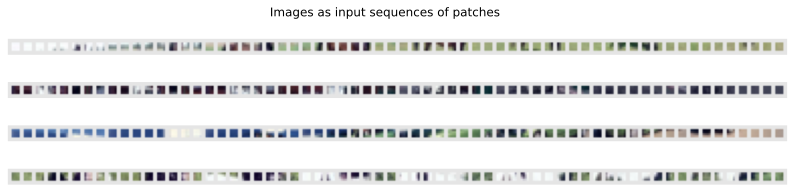

Shape of the image patches: (4, 64, 4, 4, 3)


In [356]:
img_patches = img_to_patch(CIFAR_images, patch_size=4, flatten_channels=False)

fig, ax = plt.subplots(CIFAR_images.shape[0], 1, figsize=(14,3))
fig.suptitle("Images as input sequences of patches")
for i in range(CIFAR_images.shape[0]):
    img_grid = torchvision.utils.make_grid(numpy_to_torch(img_patches[i]),
                                           nrow=64, normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis('off')
plt.show()
plt.close()
print("Shape of the image patches:", img_patches.shape)


(4, 64, 4, 4, 3)
(64,)


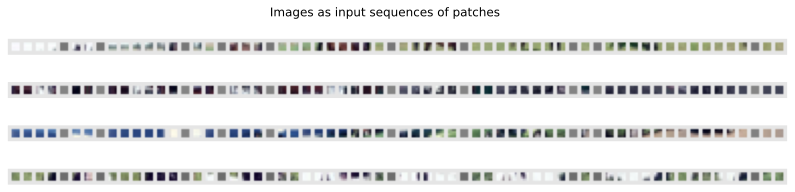

In [422]:
# mask
def mask_patch(x,mask_ratio,rng):
    """
    Mask out patches of the input image given a mask ratio.
    """
    B, H, W, C = x.shape
    # Create a random mask of shape B
    mask = jax.random.bernoulli(rng, mask_ratio, shape=(B,))
    # Set x to zero where mask is True along the batch dimension
    x = x.at[mask, :, :, :].set(0)
    print(mask.shape)
    return x

img_patches = img_to_patch(CIFAR_images, patch_size=4, flatten_channels=False)
img_patches_masked = jax.vmap(mask_patch,in_axes=(0,None,None))
rng_key_1, main_rng = jax.random.split(main_rng)
img_patches_masked = img_patches_masked(img_patches,0.1,rng_key_1)


# plot the img_patches_masked
fig, ax = plt.subplots(CIFAR_images.shape[0], 1, figsize=(14,3))
fig.suptitle("Images as input sequences of patches")
for i in range(CIFAR_images.shape[0]):
    img_grid = torchvision.utils.make_grid(numpy_to_torch(img_patches_masked[i]),
                                           nrow=64, normalize=True, pad_value=0.9)
    img_grid = img_grid.permute(1, 2, 0)
    ax[i].imshow(img_grid)
    ax[i].axis('off')
plt.show()
plt.close()